In [1]:
import records
from pprint import pprint

Proyecto final: _¿Qué tan aleatorias son las mutaciones en el cáncer?_
========================================

> Andrés García García

Base de datos
=============

![icgc](Welcome ICGC Data Portal.png)

Datos
=====

In [92]:
!head -n15 ../data/ssm_mixed.vcf

##fileformat=VCFv4.1
##INFO=<ID=CONSEQUENCE,Number=.,Type=String,Description="Mutation consequence predictions annotated by SnpEff (subfields: gene_symbol|gene_affected|gene_strand|transcript_name|transcript_affected|protein_affected|consequence_type|cds_mutation|aa_mutation)">
##INFO=<ID=OCCURRENCE,Number=.,Type=String,Description="Mutation occurrence counts broken down by project (subfields: project_code|affected_donors|tested_donors|frequency)">
##INFO=<ID=affected_donors,Number=1,Type=Integer,Description="Number of donors with the current mutation">
##INFO=<ID=mutation,Number=1,Type=String,Description="Somatic mutation definition">
##INFO=<ID=project_count,Number=1,Type=Integer,Description="Number of projects with the current mutation">
##INFO=<ID=tested_donors,Number=1,Type=Integer,Description="Total number of donors with SSM data available">
##comment=ICGC open access Simple Somatic Mutations (SSM) data dump in VCF format
##fileDate=2016-11-30T18:31:43.208-05:00
##geneModel=ENSEM

Obteniendo los datos
===========

![db](https://azure.microsoft.com/svghandler/sql-database/?width=600&height=315)

![db_structure](https://s3.amazonaws.com/dev.assets.neo4j.com/wp-content/uploads/from_relational_model.png)

In [1]:
%ls ../data/data-release-25

ssm_alt.sqlite  ssm.sqlite  ssm.vcf


In [2]:
database = records.Database('sqlite:///../data/data-release-25/ssm_alt.sqlite')
database.get_table_names()

['mutations']

In [8]:
print(database.query('SELECT * FROM mutations')[:100].dataset)

chromosome|GRCh37_pos|mutation_id|reference_allele                   |mutated_allele     |quality|filter|affected_donors|mutation                                               |project_count|studies|tested_donors|consequence                                                                               |occurrence_by_project
----------|----------|-----------|-----------------------------------|-------------------|-------|------|---------------|-------------------------------------------------------|-------------|-------|-------------|------------------------------------------------------------------------------------------|---------------------
1         |1000000   |MU88749506 |T                                  |.                  |.      |.     |23             |T>T                                                    |1            |.      |12198        |.                                                                                         |NKTL-SG|23|23|1.00000
1         |100000022 |

In [3]:
# Prepare query
bases = 'ACGT'
possible_snp = [f"'{first}>{second}'" for first in bases for second in bases if first!=second]
print(possible_snp)

# Perform the query
mutations_q = database.query( f"SELECT mutation,COUNT(mutation) FROM mutations \
                                WHERE mutation IN ({','.join(possible_snp)})\
                                GROUP BY mutation")

["'A>C'", "'A>G'", "'A>T'", "'C>A'", "'C>G'", "'C>T'", "'G>A'", "'G>C'", "'G>T'", "'T>A'", "'T>C'", "'T>G'"]


In [23]:
print(mutations_q.dataset)
counts = dict(item for item in mutations_q)

mutation|COUNT(mutation)
--------|---------------
A>C     |6962506        
A>G     |12841770       
A>T     |7046119        
C>A     |9364873        
C>G     |5937491        
C>T     |46016640       
G>A     |45821923       
G>C     |5924647        
G>T     |13862637       
T>A     |7042510        
T>C     |12824641       
T>G     |7016826        


In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

__Hipótesis nula ($H_0$)__: Todas las mutaciones son igual de probables y siguen una misma distribución gaussiana con media y varianza determinada.

__Hipótesis alternativa ($H_1$)__: No todas las medias son iguales $\mu_i =_? \mu_j$. Hay mutaciones que suceden más frecuentemente que otras.

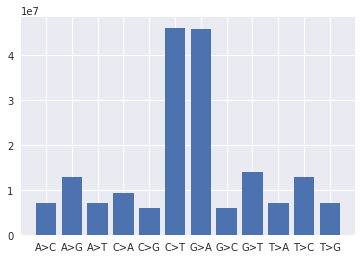

In [24]:
plt.bar(counts.keys(), counts.values());
plt.savefig('snp_frequency.png')

In [13]:
import numpy as np
import pandas as pd
import scipy

In [15]:
data = list(counts.values())

shapiro_results = scipy.stats.shapiro(data)

matrix_sw = [
    ['', 'data points', 'Test Statistic', 'p-value'],
    ['Sample Data', len(data), shapiro_results[0], shapiro_results[1]]
]

pd.DataFrame(matrix_sw)

,0,1,2,3
0,,data points,Test Statistic,p-value
1,Sample Data,12,0.619907,0.000158009


In [8]:
chromosomes = database.query("""SELECT DISTINCT chromosome FROM mutations""")
avail_chrom = [c.chromosome for c in chromosomes]
print(avail_chrom)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'MT', 'X', 'Y']


In [10]:
data = []
for chr in avail_chrom:
    query = database.query(f"SELECT mutation,COUNT(mutation) FROM mutations \
                            WHERE mutation IN ({','.join(possible_snp)})\
                            AND chromosome='{chr}'\
                            GROUP BY mutation")
    data.append([chr, dict(item for item in query)])
data

[['1',
  {'A>C': 506688,
   'A>G': 992478,
   'A>T': 519135,
   'C>A': 709626,
   'C>G': 490659,
   'C>T': 3624796,
   'G>A': 3544352,
   'G>C': 490587,
   'G>T': 1155272,
   'T>A': 519324,
   'T>C': 987046,
   'T>G': 515151}],
 ['10',
  {'A>C': 322448,
   'A>G': 564286,
   'A>T': 315547,
   'C>A': 413281,
   'C>G': 244157,
   'C>T': 1906541,
   'G>A': 1927278,
   'G>C': 247699,
   'G>T': 552768,
   'T>A': 318249,
   'T>C': 562307,
   'T>G': 319637}],
 ['11',
  {'A>C': 398632,
   'A>G': 683717,
   'A>T': 365927,
   'C>A': 523401,
   'C>G': 322837,
   'C>T': 2441786,
   'G>A': 2418411,
   'G>C': 322363,
   'G>T': 820432,
   'T>A': 364845,
   'T>C': 686906,
   'T>G': 395712}],
 ['12',
  {'A>C': 347352,
   'A>G': 673551,
   'A>T': 358106,
   'C>A': 476312,
   'C>G': 322641,
   'C>T': 2410165,
   'G>A': 2385264,
   'G>C': 316708,
   'G>T': 744905,
   'T>A': 355278,
   'T>C': 668729,
   'T>G': 350003}],
 ['13',
  {'A>C': 195714,
   'A>G': 330164,
   'A>T': 191250,
   'C>A': 223662,
   'C>G'

In [25]:
df = pd.DataFrame([chr_data for chr,chr_data in data]+[counts], index=[chr for chr, chr_data in data]+['all'])
df.fillna(0, inplace=True)
df.to_csv('snp_occurrence.csv')
df

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
1,506688,992478,519135,709626,490659,3624796,3544352,490587,1155272,519324,987046,515151
10,322448,564286,315547,413281,244157,1906541,1927278,247699,552768,318249,562307,319637
11,398632,683717,365927,523401,322837,2441786,2418411,322363,820432,364845,686906,395712
12,347352,673551,358106,476312,322641,2410165,2385264,316708,744905,355278,668729,350003
13,195714,330164,191250,223662,125041,1052896,1053148,125584,278788,192433,327447,194028
14,234593,446327,242740,309217,218261,1561010,1527805,215166,487092,243552,449113,245425
15,190282,372968,188805,268975,176784,1314479,1321495,178608,417315,189564,378075,191837
16,217469,404631,211463,337224,216723,1745872,1700262,215390,583841,212108,401994,222303
17,177682,396095,182816,323207,247985,1625976,1621459,239507,639085,179468,394596,179670
18,199074,351900,198748,249027,144544,1308377,1278140,147488,315995,199793,352167,200031


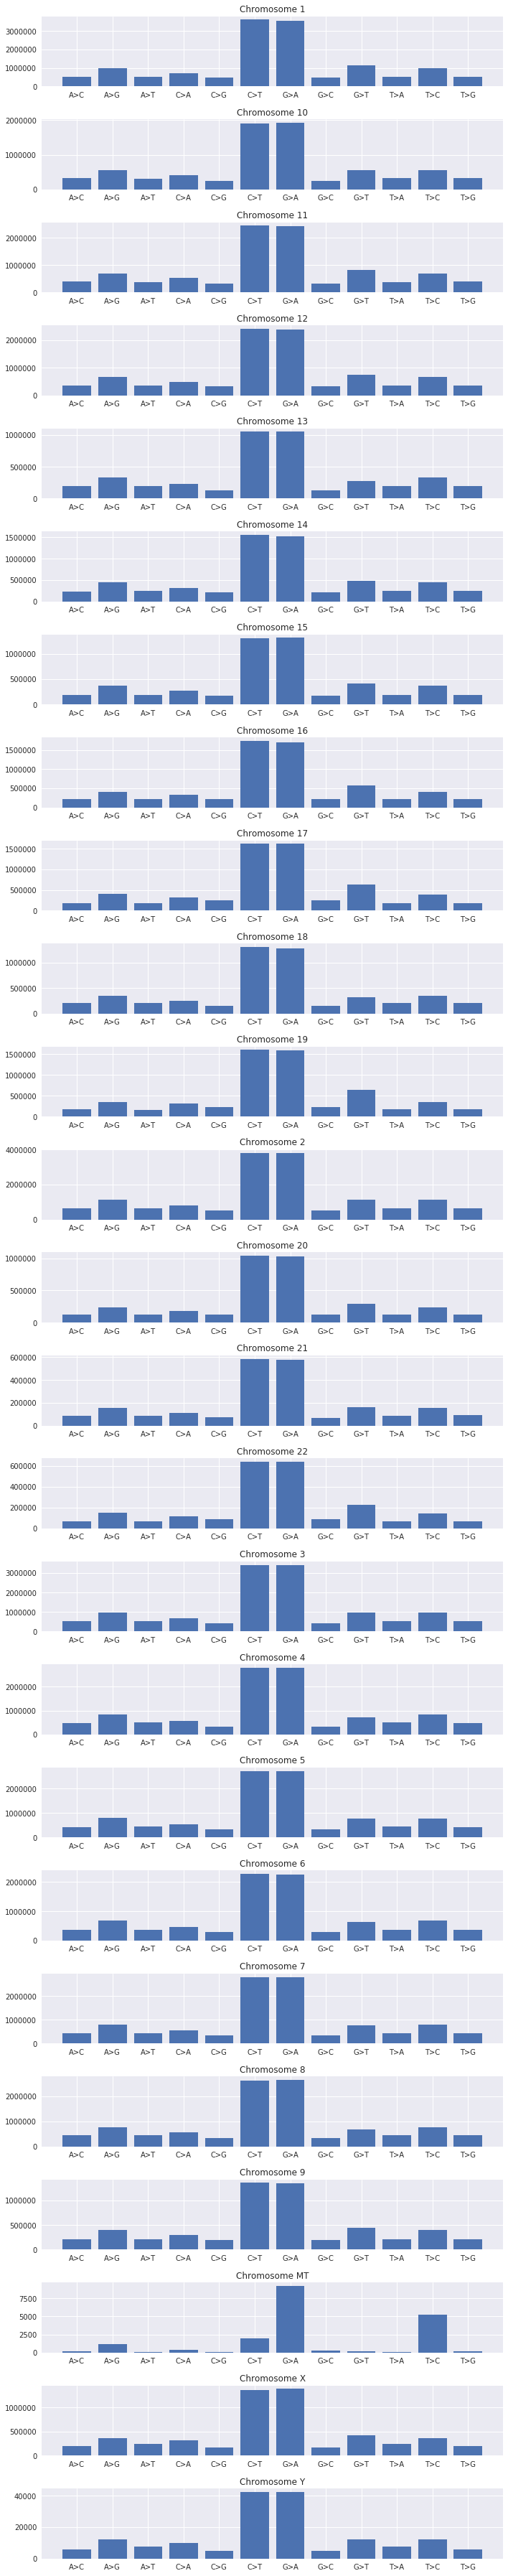

In [28]:
fig, ax = plt.subplots(len(data), 1, figsize=(10, 50))
for i, (ch, ch_counts) in enumerate(data):
    ax[i].bar(ch_counts.keys(), ch_counts.values());
    ax[i].set_title(f'Chromosome {ch}')
plt.tight_layout()
plt.savefig('snp_frequency_by_chrom.png')

In [18]:
df

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
1,506688,992478,519135,709626,490659,3624796,3544352,490587,1155272,519324,987046,515151
10,322448,564286,315547,413281,244157,1906541,1927278,247699,552768,318249,562307,319637
11,398632,683717,365927,523401,322837,2441786,2418411,322363,820432,364845,686906,395712
12,347352,673551,358106,476312,322641,2410165,2385264,316708,744905,355278,668729,350003
13,195714,330164,191250,223662,125041,1052896,1053148,125584,278788,192433,327447,194028
14,234593,446327,242740,309217,218261,1561010,1527805,215166,487092,243552,449113,245425
15,190282,372968,188805,268975,176784,1314479,1321495,178608,417315,189564,378075,191837
16,217469,404631,211463,337224,216723,1745872,1700262,215390,583841,212108,401994,222303
17,177682,396095,182816,323207,247985,1625976,1621459,239507,639085,179468,394596,179670
18,199074,351900,198748,249027,144544,1308377,1278140,147488,315995,199793,352167,200031


In [126]:

for chrom in avail_chrom:
    df.loc[chrom, :]

SyntaxError: invalid syntax (<ipython-input-126-c6773fe1a721>, line 1)

In [141]:
conditions = [df.at(chrom) for chrom in avail_chrom]
conditions

ValueError: No axis named 1 for object type <class 'pandas.core.frame.DataFrame'>

In [29]:
%ls

db_setup.py*                        __pycache__/
get_recurrence_distribution.py*     Setting up the database-with ODO.ipynb*
__init__.py*                        snp_frequency_by_chrom.png
mutationparse.py*                   snp_frequency.png
mutation_recurrence.png*            snp_occurrence.csv
Proyecto probabilidad.ipynb*        ssm_datashape.py*
Proyecto probabilidad.slides.html*  Welcome ICGC Data Portal.png*
